# **Evaluación de Modelos**
---
---
##*Pontificia Universidad Javeriana*
## *myMind*

---

**Juan José Gómez Arenas**



---






# Instalación de dependencias generales

In [ ]:
%pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.7 MB/s eta 0:00:00


# Obtención de datos
Se obtienen los datos recolectados almacenados en drive

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob

# Definir rutas base en Google Drive
BASE_DIR = "/content/drive/MyDrive/Transcripcion"
AUDIO_DIR = os.path.join(BASE_DIR, "Audios")
MANUAL_TRANSCRIPTS_DIR = os.path.join(BASE_DIR, "Transcripciones_Manuales")
RESULTS_DIR = os.path.join(BASE_DIR, "Resultados")

In [ ]:
# Obtener lista de audios
audio_files = glob.glob(os.path.join(AUDIO_DIR, "*.wav"))

In [ ]:
audio_files[0:5]

['/content/drive/MyDrive/Transcripcion/Audios/A053.wav',
 '/content/drive/MyDrive/Transcripcion/Audios/A069.wav',
 '/content/drive/MyDrive/Transcripcion/Audios/A065.wav',
 '/content/drive/MyDrive/Transcripcion/Audios/A066.wav',
 '/content/drive/MyDrive/Transcripcion/Audios/A060.wav']

# Metricas de evaluación
Para esta sección se crearan funciones que permiten estructurar el procesamiento de los audios y la evaluación de las transcripciones. `get_manual_transcription()` recupera la transcripción manual correspondiente a cada audio. `calculate_metrics()` compara la transcripción generada por los modelos con la manual, calculando métricas clave:
- *WER (Word Error Rate)* mide la tasa de errores de palabras
- *WA (Word Accuracy)* mide la tasa de presición en terminos de palabras correctamente transcritas
- *CER (Character Error Rate)* evalúa errores a nivel de caracteres
- *WPM (Words Per Minute)* determina la velocidad de transcripción dividiendo el número de palabras por la duración del audio en minutos.

Estas métricas permiten analizar la precisión y eficiencia de cada modelo, de manera que se pueda seleccionar el modelo que obtenga mejor rendimiento y que sea mas pertinente para la aplicación de myMind en terminos de ASR (Automatic Speech Recognition)

In [ ]:
import librosa

def words_per_minute(text, audio_path):
    """Calcula la velocidad de transcripción en palabras por minuto (WPM) con duración real del audio."""
    word_count = len(text.split())
    duration = librosa.get_duration(path=audio_path)  # Obtener duración en segundos
    return word_count / (duration / 60)

In [ ]:
# Función para calcular métricas
from jiwer import wer, cer

def calculate_metrics(reference, hypothesis, execution_time):
    """Calcula WER, CER, Levenshtein, WPM y el tiempo de ejecución."""
    word_error_rate = wer(reference, hypothesis)
    return {
        "WER": word_error_rate,
        "WA": 1 - word_error_rate,
        "CER": cer(reference, hypothesis),
        "WPM": words_per_minute(hypothesis),
        "Execution Time (s)": execution_time
    }

# Modelos
A partir de la investigación realizada se pudieron identificar varios modelos relevantes para la transcripción de texto, de manera que a continuación se evalua el rendimiento de ellos.

## Whisper

In [ ]:
# Instalar Whisper
%%capture
%pip install openai-whisper jiwer librosa
%pip install torch


In [ ]:
import whisper
import os
import time
import torch

# Directorios
AUDIO_DIR = "/content/drive/MyDrive/Transcripcion/Audios"
RESULTS_DIR = "/content/drive/MyDrive/Transcripcion/Resultados"

# Modelos a probar
WHISPER_SIZES = ["tiny", "small", "medium", "large"]

# Configuración de dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

# Función de transcripción con Whisper
def transcribe_whisper(model_size, audio_path):
    """Ejecuta transcripción con Whisper y mide tiempo de ejecución."""
    model = whisper.load_model(model_size, device=DEVICE)
    start_time = time.time()
    result = model.transcribe(audio_path, language="es")
    execution_time = time.time() - start_time
    return result["text"], execution_time

# Procesar audios con Whisper
for model_size in WHISPER_SIZES:
    model_results_dir = os.path.join(RESULTS_DIR, f"Whisper_{model_size}")
    os.makedirs(model_results_dir, exist_ok=True)

    for audio_file in os.listdir(AUDIO_DIR):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(AUDIO_DIR, audio_file)
            transcript_file = os.path.join(model_results_dir, audio_file.replace(".wav", "_T.txt"))
            metrics_file = os.path.join(model_results_dir, audio_file.replace(".wav", "_Metrics.txt"))

            # Verificación antes de transcribir
            if os.path.exists(transcript_file):
                print(f"Skipping {audio_file}, transcription already exists for {model_size}.")
                continue

            # Ejecutar transcripción
            hypothesis, exec_time = transcribe_whisper(model_size, audio_path)

            # Guardar transcripción
            with open(transcript_file, "w", encoding="utf-8") as f:
                f.write(hypothesis)

            # Calcular WPM
            wpm = words_per_minute(hypothesis, audio_path)

            # Guardar métricas (Tiempo y WPM)
            with open(metrics_file, "w", encoding="utf-8") as f:
                f.write(f"Execution Time (s): {exec_time:.2f}\n")
                f.write(f"WPM: {wpm:.2f}\n")

            print(f"Whisper {model_size} | Audio: {audio_file} -> Execution Time: {exec_time:.2f}s | WPM: {wpm:.2f}")


Usando dispositivo: cpu


100%|█████████████████████████████████████| 72.1M/72.1M [00:01<00:00, 67.3MiB/s]


Whisper tiny | Audio: A053.wav -> Execution Time: 10.90s | WPM: 125.75
Whisper tiny | Audio: A069.wav -> Execution Time: 24.96s | WPM: 125.09
Whisper tiny | Audio: A065.wav -> Execution Time: 3.74s | WPM: 139.35
Whisper tiny | Audio: A066.wav -> Execution Time: 3.70s | WPM: 115.95
Whisper tiny | Audio: A060.wav -> Execution Time: 6.82s | WPM: 155.03
Whisper tiny | Audio: A062.wav -> Execution Time: 4.65s | WPM: 144.50
Whisper tiny | Audio: A068.wav -> Execution Time: 3.24s | WPM: 139.77
Whisper tiny | Audio: A061.wav -> Execution Time: 5.51s | WPM: 163.03
Whisper tiny | Audio: A067.wav -> Execution Time: 4.08s | WPM: 114.93
Whisper tiny | Audio: A064.wav -> Execution Time: 6.11s | WPM: 165.09
Whisper tiny | Audio: A063.wav -> Execution Time: 4.30s | WPM: 140.53
Whisper tiny | Audio: A056.wav -> Execution Time: 5.45s | WPM: 143.45
Whisper tiny | Audio: A055.wav -> Execution Time: 4.55s | WPM: 123.84
Whisper tiny | Audio: A001.wav -> Execution Time: 11.15s | WPM: 70.23
Whisper tiny | Aud

100%|███████████████████████████████████████| 461M/461M [00:10<00:00, 45.6MiB/s]


Whisper small | Audio: A053.wav -> Execution Time: 25.40s | WPM: 117.89
Whisper small | Audio: A069.wav -> Execution Time: 30.02s | WPM: 119.88
Whisper small | Audio: A065.wav -> Execution Time: 15.96s | WPM: 134.54
Whisper small | Audio: A066.wav -> Execution Time: 25.70s | WPM: 112.39
Whisper small | Audio: A060.wav -> Execution Time: 46.59s | WPM: 155.03
Whisper small | Audio: A062.wav -> Execution Time: 30.75s | WPM: 146.31
Whisper small | Audio: A068.wav -> Execution Time: 14.55s | WPM: 134.28
Whisper small | Audio: A061.wav -> Execution Time: 28.47s | WPM: 159.67
Whisper small | Audio: A067.wav -> Execution Time: 27.57s | WPM: 122.69
Whisper small | Audio: A064.wav -> Execution Time: 31.30s | WPM: 158.35
Whisper small | Audio: A063.wav -> Execution Time: 29.13s | WPM: 138.90
Whisper small | Audio: A056.wav -> Execution Time: 28.85s | WPM: 138.87
Whisper small | Audio: A055.wav -> Execution Time: 28.06s | WPM: 119.42
Whisper small | Audio: A001.wav -> Execution Time: 63.45s | WPM:

100%|█████████████████████████████████████| 2.88G/2.88G [00:53<00:00, 57.3MiB/s]


Whisper large | Audio: A053.wav -> Execution Time: 151.51s | WPM: 129.67


Al realizar la prueba con el modelo large, el entorno fallo, por la siguiente razon:
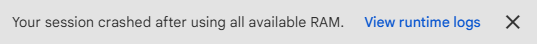

Tomando esto en consideración y teniendo en cuenta que el entorno tiene una capacidad de mas de 12 GB de RAM, además de las limitaciones de los recursos con los que cuenta el equipo, se decide omitir la prueba de este modelo ya que no cumple con las necesidades que tiene la aplicación.

## Whisper X

In [ ]:
!pip install -q whisperx

In [ ]:
import whisperx
import os
import time
import torch

# Modelos a probar
WHISPERX_SIZES = ["medium", "large"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

# Procesar audios con WhisperX
for model_size in WHISPERX_SIZES:
    model_results_dir = os.path.join(RESULTS_DIR, f"WhisperX_{model_size}")
    os.makedirs(model_results_dir, exist_ok=True)

    # Cargar modelo de WhisperX
    model = whisperx.load_model(model_size, DEVICE)

    for audio_file in os.listdir(AUDIO_DIR):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(AUDIO_DIR, audio_file)
            transcript_file = os.path.join(model_results_dir, audio_file.replace(".wav", "_T.txt"))

            # Transcripción
            start_time = time.time()
            result = model.transcribe(audio_path, language="es")
            execution_time = time.time() - start_time
            transcript = result["text"]

            # Guardar transcripción
            with open(transcript_file, "w", encoding="utf-8") as f:
                f.write(transcript)

            # Calcular WPM
            wpm = words_per_minute(transcript, audio_path)

            # Guardar métricas básicas (WPM y tiempo de ejecución)
            metrics_file = os.path.join(model_results_dir, audio_file.replace(".wav", "_Metrics.txt"))
            with open(metrics_file, "w", encoding="utf-8") as f:
                f.write(f"Execution Time (s): {execution_time:.2f}\n")
                f.write(f"WPM: {wpm:.2f}\n")

            print(f"WhisperX {model_size} | Audio: {audio_file} -> Execution Time: {execution_time:.2f}s, WPM: {wpm:.2f}")


## Wav2Vec

In [ ]:
%%capture
!pip install transformers torchaudio librosa


In [ ]:
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
import os
import time

#  Modelos a probar
WAV2VEC_MODELS = {
    "base": "facebook/wav2vec2-base-960h",
    "medium": "facebook/wav2vec2-large-xlsr-53-spanish",
    "large": "facebook/wav2vec2-large-960h"
}

#  Configuración de dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

#  Función para transcribir audio
def transcribe_wav2vec(model_name, audio_path):
    """Ejecuta transcripción con Wav2Vec 2.0 y mide tiempo de ejecución."""
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2ForCTC.from_pretrained(model_name).to(DEVICE)

    # Cargar audio
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.squeeze()

    #  Convertir a 16kHz si es necesario
    if sample_rate != 16000:
        transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = transform(waveform)

    # Preparar entrada
    input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values.to(DEVICE)

    #  Transcribir
    start_time = time.time()
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    execution_time = time.time() - start_time

    return transcription, execution_time

# Procesar audios con Wav2Vec 2.0
for model_size, model_name in WAV2VEC_MODELS.items():
    model_results_dir = os.path.join(RESULTS_DIR, f"Wav2Vec_{model_size}")
    os.makedirs(model_results_dir, exist_ok=True)

    for audio_file in os.listdir(AUDIO_DIR):
        if audio_file.endswith(".wav"):
            audio_path = os.path.join(AUDIO_DIR, audio_file)
            transcript_file = os.path.join(model_results_dir, audio_file.replace(".wav", "_T.txt"))
            metrics_file = os.path.join(model_results_dir, audio_file.replace(".wav", "_Metrics.txt"))

            # Verificación antes de transcribir
            if os.path.exists(transcript_file):
                print(f"Skipping {audio_file}, transcription already exists for {model_size}.")
                continue

            # Ejecutar transcripción
            hypothesis, exec_time = transcribe_wav2vec(model_name, audio_path)

            # Guardar transcripción
            with open(transcript_file, "w", encoding="utf-8") as f:
                f.write(hypothesis)

            # Calcular WPM (si quieres, agrégalo)
            wpm = len(hypothesis.split()) / (exec_time / 60)

            #  Guardar métricas
            with open(metrics_file, "w", encoding="utf-8") as f:
                f.write(f"Execution Time (s): {exec_time:.2f}\n")
                f.write(f"WPM: {wpm:.2f}\n")

            print(f"Wav2Vec {model_size} | Audio: {audio_file} -> Execution Time: {exec_time:.2f}s | WPM: {wpm:.2f}")


Usando dispositivo: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec base | Audio: A053.wav -> Execution Time: 10.57s | WPM: 312.25


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec base | Audio: A069.wav -> Execution Time: 12.29s | WPM: 283.13


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec base | Audio: A065.wav -> Execution Time: 17.36s | WPM: 186.64


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec base | Audio: A066.wav -> Execution Time: 12.36s | WPM: 325.19


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec base | Audio: A060.wav -> Execution Time: 24.49s | WPM: 191.11


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec base | Audio: A062.wav -> Execution Time: 11.55s | WPM: 233.69


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

##SpeechBrain

In [ ]:
%%capture
!pip install speechbrain transformers


In [ ]:
import os
import time
from speechbrain.inference.ASR import EncoderASR

# Directorios
AUDIO_DIR = "/content/drive/MyDrive/Transcripcion/Audios"
RESULTS_DIR = "/content/drive/MyDrive/Transcripcion/Resultados/SpeechBrain"

# Crear directorio si no existe
os.makedirs(RESULTS_DIR, exist_ok=True)

# Cargar el modelo preentrenado de SpeechBrain (wav2vec2 para español)
asr_model = EncoderASR.from_hparams(
    source="speechbrain/asr-wav2vec2-commonvoice-14-es",
    savedir="pretrained_models/asr-wav2vec2-commonvoice-14-es"
)

# Función de transcripción con SpeechBrain
def transcribe_speechbrain(audio_path):
    """Ejecuta transcripción con SpeechBrain y mide tiempo de ejecución."""
    start_time = time.time()
    transcription = asr_model.transcribe_file(audio_path)
    execution_time = time.time() - start_time
    return transcription, execution_time

# Procesar audios con SpeechBrain
for audio_file in os.listdir(AUDIO_DIR):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(AUDIO_DIR, audio_file)
        transcript_file = os.path.join(RESULTS_DIR, audio_file.replace(".wav", "_T.txt"))
        metrics_file = os.path.join(RESULTS_DIR, audio_file.replace(".wav", "_Metrics.txt"))

        # Verificar si ya existe la transcripción
        if os.path.exists(transcript_file):
            print(f"Skipping {audio_file}, transcription already exists.")
            continue

        # Ejecutar transcripción
        hypothesis, exec_time = transcribe_speechbrain(audio_path)

        # Calcular WPM
        word_count = len(hypothesis.split())  # Contar palabras
        wpm = word_count / (exec_time / 60) if exec_time > 0 else 0  # Evitar división por cero

        # Guardar transcripción
        with open(transcript_file, "w", encoding="utf-8") as f:
            f.write(hypothesis)

        # Guardar métricas
        with open(metrics_file, "w", encoding="utf-8") as f:
            f.write(f"Execution Time (s): {exec_time:.2f}\n")
            f.write(f"Word Count: {word_count}\n")
            f.write(f"WPM: {wpm:.2f}\n")

        print(f"SpeechBrain | Audio: {audio_file} -> Execution Time: {exec_time:.2f}s | WPM: {wpm:.2f}")


SpeechBrain | Audio: A009.wav -> Execution Time: 28.09s | WPM: 104.67
SpeechBrain | Audio: A008.wav -> Execution Time: 21.87s | WPM: 109.72
SpeechBrain | Audio: A007.wav -> Execution Time: 18.91s | WPM: 123.74
SpeechBrain | Audio: A006.wav -> Execution Time: 186.50s | WPM: 46.01
SpeechBrain | Audio: A005.wav -> Execution Time: 72.63s | WPM: 76.83
SpeechBrain | Audio: A004.wav -> Execution Time: 130.28s | WPM: 38.68
SpeechBrain | Audio: A003.wav -> Execution Time: 19.05s | WPM: 85.02
SpeechBrain | Audio: A002.wav -> Execution Time: 23.34s | WPM: 95.11
SpeechBrain | Audio: A001.wav -> Execution Time: 34.25s | WPM: 66.58
SpeechBrain | Audio: A038.wav -> Execution Time: 10.06s | WPM: 172.98
SpeechBrain | Audio: A018.wav -> Execution Time: 83.74s | WPM: 80.25
SpeechBrain | Audio: A017.wav -> Execution Time: 82.01s | WPM: 76.82
SpeechBrain | Audio: A016.wav -> Execution Time: 74.23s | WPM: 90.53
SpeechBrain | Audio: A015.wav -> Execution Time: 75.86s | WPM: 83.84
SpeechBrain | Audio: A014.wa

## Qwen2Audio
Este modelo fue mencionado en el overleaf, es un LLM, analisis mas profundo de audio.

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install librosa soundfile torch

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-xcy4mquq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-xcy4mquq
  Resolved https://github.com/huggingface/transformers to commit fc8764c9a618add64c33e83720f974750bcd0978
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10938856 sha256=25d764df34090a9e5d9c67c60134771dd8a8ccb5f24a0290f5425a90847b2a7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ic_qmufo/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 📌 Importar librerías
import torch
import librosa
import soundfile as sf
import os
import time
import pandas as pd
from transformers import Qwen2AudioForConditionalGeneration, AutoProcessor

# 📌 Configurar rutas
audio_folder = "/content/drive/MyDrive/Transcripcion/Audios/"
output_folder = "/content/drive/MyDrive/Transcripcion/Resultados/Qwen2-Audio-7B-Instruct/"
os.makedirs(output_folder, exist_ok=True)

# 📌 Cargar el modelo
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
model = Qwen2AudioForConditionalGeneration.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct", torch_dtype=torch.float16, device_map="cuda" if torch.cuda.is_available() else "cpu")

# 📌 Obtener archivos de audio
audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav")]

# 📌 Inicializar DataFrame para métricas
metrics = []

# 📌 Iniciar temporizador general
start_time_total = time.time()

# 📌 Transcribir audios
for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)

    # Cargar audio y medir duración
    audio, sr = librosa.load(audio_path, sr=processor.feature_extractor.sampling_rate)
    duration_sec = librosa.get_duration(y=audio, sr=sr)

    # Definir la conversación (solo usamos el audio)
    conversation = [{"role": "user", "content": [{"type": "audio", "audio_url": audio_path}]}]

    # Procesar entrada
    text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
    inputs = processor(text=text, audios=[audio], return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 🔹 Medir tiempo de transcripción
    start_time = time.time()
    generate_ids = model.generate(**inputs, max_length=256)
    generate_ids = generate_ids[:, inputs["input_ids"].size(1):]  # Remover prompt inicial
    transcription = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    end_time = time.time()

    # Calcular tiempo de ejecución y WPM
    execution_time = end_time - start_time
    word_count = len(transcription.split())
    WPM = (word_count / execution_time) * 60 if execution_time > 0 else 0

    # Guardar transcripción
    output_path = os.path.join(output_folder, f"{audio_file.replace('.wav', '_T_QA.txt')}")
    with open(output_path, "w") as f:
        f.write(transcription)

    # Guardar métricas en lista
    metrics.append([audio_file, duration_sec, execution_time, word_count, WPM])

    print(f"✅ Transcrito: {audio_file} -> {output_path} | ⏱ Tiempo: {execution_time:.2f}s | 📝 WPM: {WPM:.2f}")

# 🔹 Tiempo total
end_time_total = time.time()
total_time = end_time_total - start_time_total
print(f"\n🎉 Transcripción completa en {total_time:.2f} segundos.")

# 📌 Guardar métricas en CSV
metrics_df = pd.DataFrame(metrics, columns=["Archivo", "Duración (s)", "Tiempo Ejecución (s)", "Palabras", "WPM"])
metrics_csv_path = os.path.join(output_folder, "metricas_qwen2_audio.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Métricas guardadas en {metrics_csv_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Al ser mas pesado y no ser unicamente de transcripción, el modelo no pudo ser utilizado en el entorno, por consumir mucha RAM

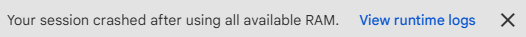

## Kaldi

In [ ]:
# Instalar Vosk y dependencias
%%capture
!pip install vosk
!apt-get install ffmpeg -y

In [ ]:
# Importar librerías necesarias
import os
import time
import wave
import json
from vosk import Model, KaldiRecognizer
from pathlib import Path

# Definir rutas
AUDIO_DIR = "/content/drive/MyDrive/Transcripcion/Audios"
RESULTS_DIR = "/content/drive/MyDrive/Transcripcion/Resultados"
MODEL_NAME = "Kaldi_Vosk"  # Nombre del modelo para organizar resultados
MODEL_DIR = os.path.join(RESULTS_DIR, MODEL_NAME)

# Crear carpeta de resultados si no existe
os.makedirs(MODEL_DIR, exist_ok=True)

# Descargar modelo de Vosk en español si no existe
if not os.path.exists("model"):
    !wget https://alphacephei.com/vosk/models/vosk-model-small-es-0.42.zip
    !unzip vosk-model-small-es-0.42.zip
    !mv vosk-model-small-es-0.42 model

# Cargar el modelo de Vosk
model = Model("model")

# Función para calcular Words Per Minute (WPM)
def words_per_minute(text, audio_path):
    with wave.open(audio_path, "rb") as wf:
        duration = wf.getnframes() / wf.getframerate()  # Duración en segundos
    words = len(text.split())
    return (words / duration) * 60 if duration > 0 else 0

# Función para transcribir audio
def transcribir_audio(ruta_audio):
    with wave.open(ruta_audio, "rb") as wf:
        if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
            raise ValueError("El archivo de audio debe estar en formato WAV mono PCM de 16 bits")

        recognizer = KaldiRecognizer(model, wf.getframerate())
        texto_transcrito = ""

        while True:
            data = wf.readframes(4000)
            if len(data) == 0:
                break
            if recognizer.AcceptWaveform(data):
                result = json.loads(recognizer.Result())
                texto_transcrito += result.get("text", "") + " "

        return texto_transcrito.strip()

# Procesar audios
for audio_file in os.listdir(AUDIO_DIR):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(AUDIO_DIR, audio_file)
        transcript_file = os.path.join(MODEL_DIR, audio_file.replace(".wav", "_T_K.txt"))
        metrics_file = os.path.join(MODEL_DIR, audio_file.replace(".wav", "_Metrics.txt"))

        # 📌 Verificar si ya existen los archivos de transcripción y métricas
        if os.path.exists(transcript_file) and os.path.exists(metrics_file):
            print(f"🔄 {audio_file} ya ha sido procesado. Omitiendo...")
            continue  # Saltar este archivo

        # ⏳ Medir tiempo de ejecución y transcribir
        start_time = time.time()
        transcript = transcribir_audio(audio_path)
        execution_time = time.time() - start_time

        # 📊 Calcular WPM
        wpm = words_per_minute(transcript, audio_path)

        # 💾 Guardar transcripción
        with open(transcript_file, "w", encoding="utf-8") as f:
            f.write(transcript)

        # 💾 Guardar métricas
        with open(metrics_file, "w", encoding="utf-8") as f:
            f.write(f"Execution Time (s): {execution_time:.2f}\n")
            f.write(f"WPM: {wpm:.2f}\n")

        print(f"✅ Kaldi | Audio: {audio_file} -> Execution Time: {execution_time:.2f}s, WPM: {wpm:.2f}")


--2025-03-18 00:52:12--  https://alphacephei.com/vosk/models/vosk-model-small-es-0.42.zip
Resolving alphacephei.com (alphacephei.com)... 188.40.21.16, 2a01:4f8:13a:279f::2
Connecting to alphacephei.com (alphacephei.com)|188.40.21.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39817833 (38M) [application/zip]
Saving to: ‘vosk-model-small-es-0.42.zip’

vosk-model-small-es 100%[===================>]  37.97M  13.9MB/s    in 2.7s    

2025-03-18 00:52:16 (13.9 MB/s) - ‘vosk-model-small-es-0.42.zip’ saved [39817833/39817833]

Archive:  vosk-model-small-es-0.42.zip
   creating: vosk-model-small-es-0.42/
   creating: vosk-model-small-es-0.42/graph/
   creating: vosk-model-small-es-0.42/graph/phones/
  inflating: vosk-model-small-es-0.42/graph/phones/word_boundary.int  
  inflating: vosk-model-small-es-0.42/graph/Gr.fst  
  inflating: vosk-model-small-es-0.42/graph/HCLr.fst  
  inflating: vosk-model-small-es-0.42/graph/disambig_tid.int  
   creating: vosk-model-sma

## Nvidia NeMo


In [ ]:
%%capture
!pip install nemo_toolkit['asr'] torchaudio pydub
!apt-get install sox


In [ ]:
import nemo.collections.asr as nemo_asr
import os
import time
import torchaudio

# 📌 Directorios
AUDIO_DIR = "/content/drive/MyDrive/Transcripcion/Audios"
RESULTS_DIR = "/content/drive/MyDrive/Transcripcion/Resultados/Nemo"

os.makedirs(RESULTS_DIR, exist_ok=True)

# 📌 Cargar el modelo NeMo en español
print("Cargando modelo NeMo STT en español...")
asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_es_conformer_transducer_large")


# 📌 Función para calcular palabras por minuto (WPM)
def words_per_minute(transcript_text, audio_path):
    num_words = len(transcript_text.split())
    audio_info = torchaudio.info(audio_path)
    duration = audio_info.num_frames / audio_info.sample_rate
    return num_words / (duration / 60) if duration > 0 else 0


# 📌 Procesar audios con NeMo STT
for audio_file in os.listdir(AUDIO_DIR):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(AUDIO_DIR, audio_file)
        transcript_file = os.path.join(RESULTS_DIR, audio_file.replace(".wav", "_T_NM.txt"))
        metrics_file = os.path.join(RESULTS_DIR, audio_file.replace(".wav", "_Metrics.txt"))

        print(f"Procesando {audio_file} con NeMo...")

        # ⏳ Medir tiempo de ejecución
        start_time = time.time()
        hypothesis = asr_model.transcribe([audio_path])[0]  # Obtiene el objeto Hypothesis
        execution_time = time.time() - start_time

        # 📜 Extraer solo el texto de la transcripción
        transcript_text = hypothesis.text if hasattr(hypothesis, "text") else str(hypothesis)

        # 📝 Guardar transcripción
        with open(transcript_file, "w", encoding="utf-8") as f:
            f.write(transcript_text)

        # ⚡ Calcular WPM
        wpm = words_per_minute(transcript_text, audio_path)

        # 📊 Guardar métricas
        with open(metrics_file, "w", encoding="utf-8") as f:
            f.write(f"Execution Time (s): {execution_time:.2f}\n")
            f.write(f"WPM: {wpm:.2f}\n")

        print(f"✅ NeMo STT | {audio_file} -> Execution Time: {execution_time:.2f}s, WPM: {wpm:.2f}")


Cargando modelo NeMo STT en español...
[NeMo I 2025-03-17 00:36:34 nemo_logging:393] Found existing object /root/.cache/torch/NeMo/NeMo_2.2.0/stt_es_conformer_transducer_large/89ef8b9d7053f53a9eec342fd52801eb/stt_es_conformer_transducer_large.nemo.
[NeMo I 2025-03-17 00:36:34 nemo_logging:393] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.2.0/stt_es_conformer_transducer_large/89ef8b9d7053f53a9eec342fd52801eb/stt_es_conformer_transducer_large.nemo
[NeMo I 2025-03-17 00:36:34 nemo_logging:393] Instantiating model from pre-trained checkpoint
[NeMo I 2025-03-17 00:36:48 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-03-17 00:36:48 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/dataset/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: true
    trim_silence: false
    max_duration: 20
    min_duration: 0.1
    is_tarred: true
    tarred_audio_filepaths: /data/dataset/train/audio__OP_0..511_CL_.tar
    
[NeMo W 2025-03-17 00:36:48 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/dev/fisher/dev_fisher_mounted_files_manifest.json
    - /data/dev/mcv7/dev_mcv7_mou

[NeMo I 2025-03-17 00:36:48 nemo_logging:393] PADDING: 0
[NeMo I 2025-03-17 00:36:50 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0}
[NeMo I 2025-03-17 00:36:50 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0}


[NeMo W 2025-03-17 00:36:50 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: CUDA is not available


[NeMo I 2025-03-17 00:36:50 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0}


[NeMo W 2025-03-17 00:36:50 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: CUDA is not available


[NeMo I 2025-03-17 00:36:52 nemo_logging:393] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.2.0/stt_es_conformer_transducer_large/89ef8b9d7053f53a9eec342fd52801eb/stt_es_conformer_transducer_large.nemo.
Procesando A053.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


✅ NeMo STT | A053.wav -> Execution Time: 9.67s, WPM: 123.78
Procesando A069.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.30s/it]


✅ NeMo STT | A069.wav -> Execution Time: 10.33s, WPM: 114.67
Procesando A065.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


✅ NeMo STT | A065.wav -> Execution Time: 6.32s, WPM: 132.14
Procesando A066.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.88s/it]


✅ NeMo STT | A066.wav -> Execution Time: 10.90s, WPM: 114.17
Procesando A060.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:19<00:00, 19.21s/it]


✅ NeMo STT | A060.wav -> Execution Time: 19.23s, WPM: 144.11
Procesando A062.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:09<00:00,  9.66s/it]


✅ NeMo STT | A062.wav -> Execution Time: 9.69s, WPM: 133.66
Procesando A068.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


✅ NeMo STT | A068.wav -> Execution Time: 4.86s, WPM: 128.80
Procesando A061.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.21s/it]


✅ NeMo STT | A061.wav -> Execution Time: 10.24s, WPM: 134.46
Procesando A067.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


✅ NeMo STT | A067.wav -> Execution Time: 10.77s, WPM: 114.93
Procesando A064.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]


✅ NeMo STT | A064.wav -> Execution Time: 8.97s, WPM: 146.56
Procesando A063.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.63s/it]


✅ NeMo STT | A063.wav -> Execution Time: 10.66s, WPM: 147.07
Procesando A056.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:11<00:00, 11.17s/it]


✅ NeMo STT | A056.wav -> Execution Time: 11.20s, WPM: 137.34
Procesando A055.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:11<00:00, 11.51s/it]


✅ NeMo STT | A055.wav -> Execution Time: 11.53s, WPM: 116.47
Procesando A001.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


✅ NeMo STT | A001.wav -> Execution Time: 6.99s, WPM: 87.78
Procesando A058.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:12<00:00, 12.55s/it]


✅ NeMo STT | A058.wav -> Execution Time: 12.58s, WPM: 165.40
Procesando A057.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:15<00:00, 15.96s/it]


✅ NeMo STT | A057.wav -> Execution Time: 16.00s, WPM: 152.48
Procesando A059.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:17<00:00, 17.95s/it]


✅ NeMo STT | A059.wav -> Execution Time: 17.98s, WPM: 114.80
Procesando A032.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


✅ NeMo STT | A032.wav -> Execution Time: 8.84s, WPM: 158.64
Procesando A035.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.21s/it]


✅ NeMo STT | A035.wav -> Execution Time: 8.24s, WPM: 93.71
Procesando A031.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:09<00:00,  9.81s/it]


✅ NeMo STT | A031.wav -> Execution Time: 9.83s, WPM: 204.52
Procesando A054.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


✅ NeMo STT | A054.wav -> Execution Time: 8.32s, WPM: 125.15
Procesando A029.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


✅ NeMo STT | A029.wav -> Execution Time: 9.05s, WPM: 153.23
Procesando A033.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:17<00:00, 17.54s/it]


✅ NeMo STT | A033.wav -> Execution Time: 17.56s, WPM: 150.10
Procesando A030.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]


✅ NeMo STT | A030.wav -> Execution Time: 7.66s, WPM: 167.91
Procesando A028.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:09<00:00,  9.51s/it]


✅ NeMo STT | A028.wav -> Execution Time: 9.53s, WPM: 172.87
Procesando A026.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


✅ NeMo STT | A026.wav -> Execution Time: 10.07s, WPM: 171.29
Procesando A034.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:23<00:00, 23.06s/it]


✅ NeMo STT | A034.wav -> Execution Time: 23.08s, WPM: 92.93
Procesando A019.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:16<00:00, 16.88s/it]


✅ NeMo STT | A019.wav -> Execution Time: 16.91s, WPM: 126.94
Procesando A025.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


✅ NeMo STT | A025.wav -> Execution Time: 7.48s, WPM: 155.29
Procesando A022.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


✅ NeMo STT | A022.wav -> Execution Time: 9.21s, WPM: 222.78
Procesando A023.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:14<00:00, 14.40s/it]


✅ NeMo STT | A023.wav -> Execution Time: 14.43s, WPM: 160.04
Procesando A027.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.50s/it]


✅ NeMo STT | A027.wav -> Execution Time: 8.53s, WPM: 193.74
Procesando A024.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.49s/it]


✅ NeMo STT | A024.wav -> Execution Time: 8.52s, WPM: 145.23
Procesando A020.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


✅ NeMo STT | A020.wav -> Execution Time: 9.01s, WPM: 161.09
Procesando A016.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:20<00:00, 20.61s/it]


✅ NeMo STT | A016.wav -> Execution Time: 20.64s, WPM: 140.70
Procesando A014.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:19<00:00, 19.57s/it]


✅ NeMo STT | A014.wav -> Execution Time: 19.60s, WPM: 150.85
Procesando A018.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:23<00:00, 23.55s/it]


✅ NeMo STT | A018.wav -> Execution Time: 23.58s, WPM: 160.94
Procesando A021.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


✅ NeMo STT | A021.wav -> Execution Time: 8.15s, WPM: 98.06
Procesando A015.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:22<00:00, 22.10s/it]


✅ NeMo STT | A015.wav -> Execution Time: 22.12s, WPM: 143.49
Procesando A010.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


✅ NeMo STT | A010.wav -> Execution Time: 6.45s, WPM: 144.24
Procesando A008.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.43s/it]


✅ NeMo STT | A008.wav -> Execution Time: 5.46s, WPM: 164.32
Procesando A009.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


✅ NeMo STT | A009.wav -> Execution Time: 7.10s, WPM: 170.04
Procesando A013.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:22<00:00, 22.83s/it]


✅ NeMo STT | A013.wav -> Execution Time: 22.85s, WPM: 138.24
Procesando A012.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:17<00:00, 17.59s/it]


✅ NeMo STT | A012.wav -> Execution Time: 17.62s, WPM: 125.69
Procesando A007.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


✅ NeMo STT | A007.wav -> Execution Time: 4.45s, WPM: 167.56
Procesando A017.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:23<00:00, 23.60s/it]


✅ NeMo STT | A017.wav -> Execution Time: 23.62s, WPM: 112.37
Procesando A002.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


✅ NeMo STT | A002.wav -> Execution Time: 5.10s, WPM: 103.37
Procesando A039.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


✅ NeMo STT | A039.wav -> Execution Time: 5.32s, WPM: 203.78
Procesando A036.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


✅ NeMo STT | A036.wav -> Execution Time: 4.36s, WPM: 157.60
Procesando A037.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


✅ NeMo STT | A037.wav -> Execution Time: 4.61s, WPM: 172.87
Procesando A042.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.34s/it]


✅ NeMo STT | A042.wav -> Execution Time: 10.38s, WPM: 150.42
Procesando A003.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


✅ NeMo STT | A003.wav -> Execution Time: 4.26s, WPM: 108.49
Procesando A038.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


✅ NeMo STT | A038.wav -> Execution Time: 3.13s, WPM: 173.85
Procesando A005.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:20<00:00, 20.58s/it]


✅ NeMo STT | A005.wav -> Execution Time: 20.61s, WPM: 150.44
Procesando A040.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:12<00:00, 12.81s/it]


✅ NeMo STT | A040.wav -> Execution Time: 12.84s, WPM: 137.19
Procesando A004.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:46<00:00, 46.35s/it]


✅ NeMo STT | A004.wav -> Execution Time: 46.38s, WPM: 144.12
Procesando A011.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


✅ NeMo STT | A011.wav -> Execution Time: 17.05s, WPM: 154.67
Procesando A046.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


✅ NeMo STT | A046.wav -> Execution Time: 5.14s, WPM: 157.65
Procesando A048.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


✅ NeMo STT | A048.wav -> Execution Time: 5.56s, WPM: 129.04
Procesando A006.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [01:10<00:00, 70.99s/it]


✅ NeMo STT | A006.wav -> Execution Time: 71.03s, WPM: 146.05
Procesando A041.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:09<00:00,  9.72s/it]


✅ NeMo STT | A041.wav -> Execution Time: 9.74s, WPM: 128.76
Procesando A045.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:06<00:00,  6.99s/it]


✅ NeMo STT | A045.wav -> Execution Time: 7.03s, WPM: 157.26
Procesando A047.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


✅ NeMo STT | A047.wav -> Execution Time: 8.87s, WPM: 129.37
Procesando A044.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:11<00:00, 11.51s/it]


✅ NeMo STT | A044.wav -> Execution Time: 11.55s, WPM: 103.67
Procesando A043.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


✅ NeMo STT | A043.wav -> Execution Time: 10.60s, WPM: 131.35
Procesando A049.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:07<00:00,  7.53s/it]


✅ NeMo STT | A049.wav -> Execution Time: 7.56s, WPM: 139.85
Procesando A052.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


✅ NeMo STT | A052.wav -> Execution Time: 5.61s, WPM: 148.22
Procesando A050.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


✅ NeMo STT | A050.wav -> Execution Time: 6.69s, WPM: 150.67
Procesando A051.wav con NeMo...


Transcribing: 100%|██████████| 1/1 [00:11<00:00, 11.68s/it]

✅ NeMo STT | A051.wav -> Execution Time: 11.72s, WPM: 160.61


## Kaldi Complete


In [ ]:
# Instalar Vosk y dependencias
%%capture
!pip install vosk
!apt-get install ffmpeg -y

In [ ]:
# Importar librerías necesarias
import os
import time
import wave
import json
import subprocess
from vosk import Model, KaldiRecognizer

# Definir rutas
AUDIO_DIR = "/content/drive/MyDrive/Transcripcion/Audios"
RESULTS_DIR = "/content/drive/MyDrive/Transcripcion/Resultados"
MODEL_NAME = "Kaldi_Vosk_Complete"  # Nombre del modelo para organizar resultados
MODEL_DIR = os.path.join(RESULTS_DIR, MODEL_NAME)

# Crear carpeta de resultados si no existe
os.makedirs(MODEL_DIR, exist_ok=True)

# Descargar modelo de Vosk más grande si no existe
if not os.path.exists("model"):
    !wget https://alphacephei.com/vosk/models/vosk-model-es-0.42.zip
    !unzip vosk-model-es-0.42.zip
    !mv vosk-model-es-0.42 model

# Cargar el modelo de Vosk
model = Model("model")

# Función para convertir audios a PCM 16-bit mono
def convert_to_pcm16(audio_path):
    output_path = audio_path.replace(".wav", "_converted.wav")
    command = f"ffmpeg -i {audio_path} -ac 1 -ar 16000 -sample_fmt s16 {output_path} -y"
    subprocess.run(command, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return output_path

# Función para calcular Words Per Minute (WPM)
def words_per_minute(text, audio_path):
    with wave.open(audio_path, "rb") as wf:
        duration = wf.getnframes() / wf.getframerate()  # Duración en segundos
    words = len(text.split())
    return (words / duration) * 60 if duration > 0 else 0

# Función para transcribir audio
def transcribir_audio(ruta_audio):
    with wave.open(ruta_audio, "rb") as wf:
        if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
            print(f"🔄 Convertiendo formato: {ruta_audio}")
            ruta_audio = convert_to_pcm16(ruta_audio)  # Convertir si no es PCM 16-bit mono

        recognizer = KaldiRecognizer(model, wf.getframerate())
        texto_transcrito = ""

        while True:
            data = wf.readframes(4000)
            if len(data) == 0:
                break
            if recognizer.AcceptWaveform(data):
                result = json.loads(recognizer.Result())
                texto_transcrito += result.get("text", "") + " "

        return texto_transcrito.strip()

# Procesar audios
for audio_file in sorted(os.listdir(AUDIO_DIR)):  # Ordenar para asegurar el orden correcto
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(AUDIO_DIR, audio_file)
        transcript_file = os.path.join(MODEL_DIR, audio_file.replace(".wav", "_T_K.txt"))
        metrics_file = os.path.join(MODEL_DIR, audio_file.replace(".wav", "_Metrics.txt"))

        # Verificar si ya existe la transcripción
        if os.path.exists(transcript_file):
            print(f"✅ Ya existe transcripción para: {audio_file}")
            continue  # Saltar este archivo

        try:
            # Transcripción y medición de tiempo
            start_time = time.time()
            transcript = transcribir_audio(audio_path)
            execution_time = time.time() - start_time

            # Calcular WPM
            wpm = words_per_minute(transcript, audio_path)

            # Guardar transcripción
            with open(transcript_file, "w", encoding="utf-8") as f:
                f.write(transcript)

            # Guardar métricas
            with open(metrics_file, "w", encoding="utf-8") as f:
                f.write(f"Execution Time (s): {execution_time:.2f}\n")
                f.write(f"WPM: {wpm:.2f}\n")

            print(f"🎤 Kaldi | Audio: {audio_file} -> Execution Time: {execution_time:.2f}s, WPM: {wpm:.2f}")

        except Exception as e:
            print(f"❌ Error procesando {audio_file}: {e}")


--2025-03-18 21:03:46--  https://alphacephei.com/vosk/models/vosk-model-es-0.42.zip
Resolving alphacephei.com (alphacephei.com)... 188.40.21.16, 2a01:4f8:13a:279f::2
Connecting to alphacephei.com (alphacephei.com)|188.40.21.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1484681703 (1.4G) [application/zip]
Saving to: ‘vosk-model-es-0.42.zip’

vosk-model-es-0.42. 100%[===================>]   1.38G  30.1MB/s    in 48s     

2025-03-18 21:04:34 (29.8 MB/s) - ‘vosk-model-es-0.42.zip’ saved [1484681703/1484681703]

Archive:  vosk-model-es-0.42.zip
   creating: vosk-model-es-0.42/
   creating: vosk-model-es-0.42/graph/
  inflating: vosk-model-es-0.42/graph/words.txt  
   creating: vosk-model-es-0.42/graph/phones/
  inflating: vosk-model-es-0.42/graph/phones/word_boundary.int  
  inflating: vosk-model-es-0.42/graph/HCLG.fst  
   creating: vosk-model-es-0.42/am/
  inflating: vosk-model-es-0.42/am/final.mdl  
   creating: vosk-model-es-0.42/rnnlm/
 extracting: vosk-